In [5]:
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch

from config.model_config import ModelConfig
from config.experiment_config import ExperimentConfig, AvailableDatasets
from vol_predict.features.preprocessor import OneToOnePreprocessor
from vol_predict.loss.loss import Loss

from vol_predict.models.dl.transformer_predictor import TransformerPredictor as Model
from vol_predict.models.dl.lstm_softplus_predictor import (
    LSTMSoftplusPredictor as Baseline,
)

from run import run_backtest, initialize_sequential_runner

In [7]:
config = ExperimentConfig()
config.DATASET = AvailableDatasets.BITCOIN

model_params = ModelConfig()
baseline_params = ModelConfig()

model_params.n_features = 1200
model_params.n_unique_features = 10

# Handles the features
feature_processor = OneToOnePreprocessor()

runner = initialize_sequential_runner(
    model_config=model_params,
    preprocessor=feature_processor,
    experiment_config=config,
)

Available data from 2018-06-04 23:00:00 to 2018-09-30 21:00:00


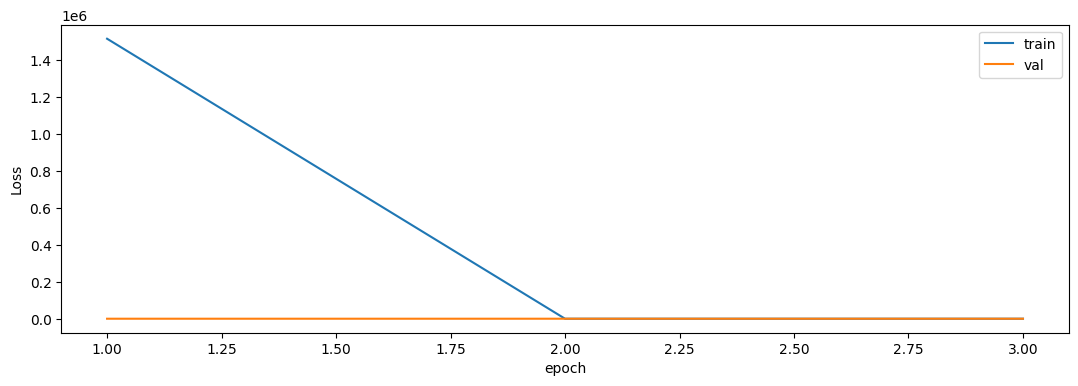

Training 4/20:  37%|███▋      | 13/35 [00:00<00:00, 43.98it/s]


KeyboardInterrupt: 

In [8]:
runner.model_config.lr = 1e-2
runner.model_config.n_epochs = 20
runner.model_config.hidden_size = 64
runner.model_config.n_layers = 3
runner.model_config.batch_size = 16
runner.model_config.optimizer = torch.optim.Adam
runner.model_config.loss = Loss.NLL
runner.model_config.dropout = 0.20

result = run_backtest(
    model_cls=Model,
    baseline_cls=Baseline,
    runner=runner,
)

In [5]:
result

(            model_loss  baseline_loss  \
 datetime                                
 2018-06-30   -0.408127      -9.620058   
 2018-07-03   -8.252933      -8.608952   
 2018-07-04    2.315962      -9.032787   
 2018-07-05   -8.556475      -9.462177   
 2018-07-06   -8.809825      -9.490600   
 ...                ...            ...   
 2018-09-26   -9.234242     -10.044114   
 2018-09-27   -0.406690      -9.559533   
 2018-09-28   -9.010862      -9.785958   
 2018-09-29  -10.263964     -10.194901   
 2018-09-30    1.087641     -10.081060   
 
                                                  true_returns  \
 datetime                                                        
 2018-06-30  [-0.0026883667, -0.004259642, 0.0017928587, 0....   
 2018-07-03                                     [-0.008161686]   
 2018-07-04  [0.00045824194, 0.001279179, -0.00041435525, 0...   
 2018-07-05  [-0.0025450767, 0.0020725208, -0.0004954421, -...   
 2018-07-06  [0.004517578, -0.0020303084, -0.0006618499,

In [6]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error

rmse = []
for (date, row) in result.iterrows():
    rmse.append([date, root_mean_squared_error(row.true_vols, row.model_preds), root_mean_squared_error(row.true_vols, row.baseline_preds)])

rmse = pd.DataFrame(rmse, columns=["date", "model", "baseline"]).set_index("date")

AttributeError: 'tuple' object has no attribute 'iterrows'

In [110]:
rmse.mean(axis=0)

model       0.000147
baseline    0.000154
dtype: float64

In [111]:
rmse.std(axis=0)

model       0.000181
baseline    0.000180
dtype: float64

In [112]:
result.to_csv(f"Daily_Transf_results_{runner.model_config.n_epochs}.csv")